<a href="https://colab.research.google.com/github/mostofk/Economic-Dispatch-using-Unit-Commitment-of-Microgrid-at-Tok-Alaska/blob/main/Tok_Microgrid_09_Feb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

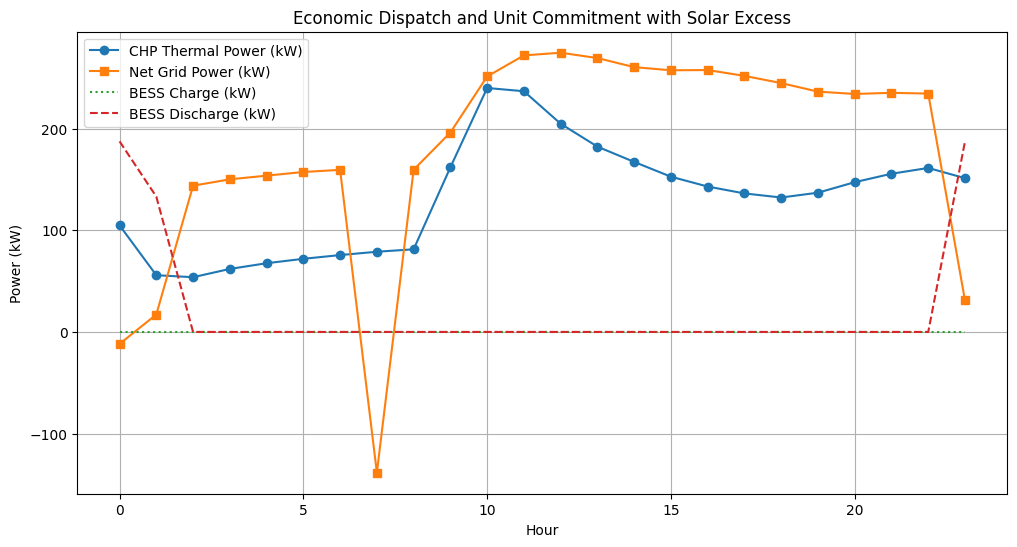

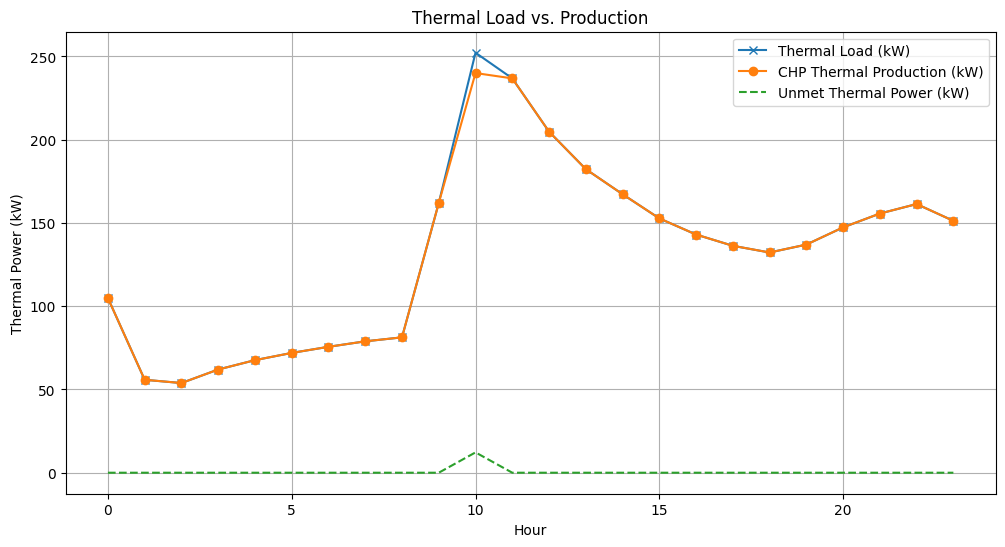

 Hours  Grid Import  Grid Export  CHP Thermal Power  CHP Electrical Power  BESS Charge  BESS Discharge  BESS Remaining Energy  Solar Production  Unmet Th Power  Overproduced Th Power  Total Cost  Total Penalty
     0        0.000       11.785             104.87                52.435          0.0         187.500             375.000000             0.000            0.00                    0.0    -1.23825           0.00
     1       17.120        0.000              55.81                27.905          0.0         133.125             177.631579             0.000            0.00                    0.0    12.20650           0.00
     2      143.865        0.000              53.85                26.925         -0.0           0.000              37.500000             0.000            0.00                    0.0    81.81825           0.00
     3      150.130        0.000              61.98                30.990         -0.0           0.000              37.500000             0.000            0.00 

In [3]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt

# Load profiles (electrical and thermal)
electrical_load = [228.15, 178.15, 170.79, 181.12, 187.57, 193.32, 197.26, 200.94, 200.19, 277.15, 371.33, 390.9,
                   380.31, 365.21, 349.28, 337.52, 329.16, 320.04, 310.94, 304.92, 307.78, 313.06, 315.16, 294.06]

thermal_load = [104.87, 55.81, 53.85, 61.98, 67.6, 71.94, 75.61, 78.9, 81.29, 161.93, 252.21, 236.8, 204.82, 182.3,
                167.25, 152.73, 143.03, 136.27, 132.25, 136.99, 147.33, 155.63, 161.34, 151.26]

# Solar power generation
solar_power = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 0.0, 0.452, 3.204,
               4.609, 5.137, 3.741, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

T = range(24)  # Time periods

# System Parameters
CHP_capacity = 120
solar_capacity = 46
BESS_capacity = 375
BESS_max_use = 187.5
BESS_min_SOC = 0.1 * BESS_capacity  # Minimum SOC (10%)
BESS_efficiency = 0.95
fuel_cost_coeff = 0.05  # Pre-calculated fuel cost coefficient
penalty_unmet_thermal = 2
grid_price = 0.55
thermal_capacity = 2 * CHP_capacity  # Maximum thermal output of CHP

# Define model
model = ConcreteModel()

# Decision Variables
model.P_CHP = Var(T, within=NonNegativeReals, bounds=(0, CHP_capacity))
model.U_CHP = Var(T, within=Binary)
model.P_BESS_charge = Var(T, within=NonNegativeReals, bounds=(0, BESS_max_use))
model.P_BESS_discharge = Var(T, within=NonNegativeReals, bounds=(0, BESS_max_use))
model.SOC_BESS = Var(T, within=NonNegativeReals, bounds=(BESS_min_SOC, BESS_capacity))
model.P_grid = Var(T, within=Reals)
model.P_unmet_thermal = Var(T, within=NonNegativeReals)
model.P_solar_excess = Var(T, within=NonNegativeReals)  # Excess solar generation
model.BESS_can_discharge = Var(T, within=Binary)  # Binary variable for discharge control

# Objective Function: Minimize total cost
model.total_cost = Objective(
    expr=sum(
        fuel_cost_coeff * (model.P_CHP[t] * 2) +  # Fuel cost based on CHP thermal production
        grid_price * model.P_grid[t] +  # Grid import cost
        penalty_unmet_thermal * model.P_unmet_thermal[t]  # Unmet thermal penalty
        for t in T
    ), sense=minimize
)

# Constraints

# Power Balance
model.power_balance = ConstraintList()
for t in T:
    if t == 10:  # Special case for hour 10 with high solar generation
        model.power_balance.add(
            model.P_CHP[t] + solar_power[t] - model.P_solar_excess[t] + model.P_BESS_discharge[t] - model.P_BESS_charge[t] + model.P_grid[t] == electrical_load[t]
        )
        model.power_balance.add(
            model.P_solar_excess[t] <= BESS_max_use - model.P_BESS_charge[t]  # Excess solar is used to charge BESS
        )
    else:
        model.power_balance.add(
            model.P_CHP[t] + solar_power[t] + model.P_BESS_discharge[t] - model.P_BESS_charge[t] + model.P_grid[t] == electrical_load[t]
        )

# Thermal Balance
model.thermal_balance = ConstraintList()
for t in T:
    model.thermal_balance.add(
        model.P_CHP[t] * 2 + model.P_unmet_thermal[t] == thermal_load[t]  # Ensure CHP produces required thermal load up to its capacity
    )
    model.thermal_balance.add(
        model.P_unmet_thermal[t] >= 0  # Unmet thermal load cannot be negative
    )
    model.thermal_balance.add(
        model.P_CHP[t] * 2 <= thermal_capacity  # Ensure thermal production does not exceed maximum capacity
    )

# CHP Commitment
model.CHP_commitment = ConstraintList()
for t in T:
    model.CHP_commitment.add(model.P_CHP[t] <= CHP_capacity * model.U_CHP[t])

# Battery SOC Dynamics and Minimum SOC Constraint
model.battery_dynamics = ConstraintList()
for t in T:
    if t == 0:
        model.battery_dynamics.add(model.SOC_BESS[t] == BESS_capacity)  # Fully charged at start
    else:
        model.battery_dynamics.add(
            model.SOC_BESS[t] == model.SOC_BESS[t-1] + BESS_efficiency * model.P_BESS_charge[t-1] - (1 / BESS_efficiency) * model.P_BESS_discharge[t-1]
        )
    # Link the binary variable with the SOC condition
    model.battery_dynamics.add(model.SOC_BESS[t] >= BESS_min_SOC - (1 - model.BESS_can_discharge[t]) * BESS_capacity)
    model.battery_dynamics.add(model.SOC_BESS[t] <= BESS_min_SOC + model.BESS_can_discharge[t] * BESS_capacity)
    # Allow discharge only if the binary variable is 1
    model.battery_dynamics.add(model.P_BESS_discharge[t] <= BESS_max_use * model.BESS_can_discharge[t])

# Solve model
solver = SolverFactory('glpk')
solver.solve(model)

# Data collection for table output
results = []
for t in T:
    grid_import = max(0, model.P_grid[t]())
    grid_export = max(0, -model.P_grid[t]())
    chp_thermal_power = model.P_CHP[t]() * 2
    chp_electrical_power = model.P_CHP[t]()
    bess_charge = model.P_BESS_charge[t]()
    bess_discharge = model.P_BESS_discharge[t]()
    bess_remaining_energy = model.SOC_BESS[t]()
    solar_production = solar_power[t]
    unmet_power = model.P_unmet_thermal[t]()
    overproduced_power = model.P_solar_excess[t]() if t == 10 else 0
    total_cost = fuel_cost_coeff * chp_thermal_power + grid_price * model.P_grid[t]() + penalty_unmet_thermal * unmet_power
    total_penalty = penalty_unmet_thermal * unmet_power
    results.append([
        t, grid_import, grid_export, chp_thermal_power, chp_electrical_power, bess_charge, bess_discharge,
        bess_remaining_energy, solar_production, unmet_power, overproduced_power, total_cost, total_penalty
    ])

# Extract data for plots
CHP_power = [result[3] for result in results]  # CHP Thermal Power
Grid_power = [result[1] - result[2] for result in results]  # Net Grid Power (Import - Export)
BESS_charge = [result[5] for result in results]  # BESS Charge
BESS_discharge = [result[6] for result in results]  # BESS Discharge
Thermal_production = [result[3] for result in results]  # Thermal Production (same as CHP Power for thermal)
Unmet_thermal = [result[9] for result in results]  # Unmet Thermal Power

# Plots
plt.figure(figsize=(12, 6))
plt.plot(T, CHP_power, label='CHP Thermal Power (kW)', marker='o')
plt.plot(T, Grid_power, label='Net Grid Power (kW)', marker='s')
plt.plot(T, BESS_charge, label='BESS Charge (kW)', linestyle='dotted')
plt.plot(T, BESS_discharge, label='BESS Discharge (kW)', linestyle='dashed')
plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.title('Economic Dispatch and Unit Commitment with Solar Excess')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(T, thermal_load, label='Thermal Load (kW)', marker='x')
plt.plot(T, Thermal_production, label='CHP Thermal Production (kW)', marker='o')
plt.plot(T, Unmet_thermal, label='Unmet Thermal Power (kW)', linestyle='--')
plt.xlabel('Hour')
plt.ylabel('Thermal Power (kW)')
plt.title('Thermal Load vs. Production')
plt.legend()
plt.grid(True)
plt.show()

# Display table
columns = [
    "Hours", "Grid Import", "Grid Export", "CHP Thermal Power", "CHP Electrical Power", "BESS Charge",
    "BESS Discharge", "BESS Remaining Energy", "Solar Production", "Unmet Th Power", "Overproduced Th Power",
    "Total Cost", "Total Penalty"
]
results_df = pd.DataFrame(results, columns=columns)
print(results_df.to_string(index=False))
